# Evaluation
* Here we compute matrices of BLEU scores, first without any alignment, then with alignment. 
* `Preparation.ipynb` was run before to create the files within `translations`

## Direct Evaluation
* Compute Scores immediately after translation
* Assumption: Alignment was preserved by the translator, so we only need to create triplets.

In [1]:
from scripts.data_management import EuroParlManager, FloresPlusManager, Opus100Manager
parts = {
    'opus': {'dm':Opus100Manager(), 'pairs':Opus100Manager.get_pairs()},
    'ep': {'dm':EuroParlManager(), 'pairs':EuroParlManager.get_pairs()},
    'flores': {'dm':FloresPlusManager(), 'pairs':FloresPlusManager.get_pairs()}
}

translators = ['gpt', 'deepl']

In [2]:
from scripts.post_process import direct_triplet_align, load_sents_from_file
from os.path import join

for dataset, content in parts.items():
    dm = content['dm']
    pairs = content['pairs']
    for pair in pairs:
        s,t = pair
        for translator in translators:
            filename = f'{dataset}-{translator}-{s}-{t}'
            mt_sents = load_sents_from_file(folder='translations', filename=filename)
            src_sents, tgt_sents = dm.get_sentence_pairs(s, t, num_of_sents=400)
            direct_triplet_align(
                mt_sents=mt_sents,
                src_sents=src_sents,
                ref_sents=tgt_sents,
                src_lang=s,
                ref_lang=t,
                folder_path='direct_triplets',
                prefix=f'{dataset}-{translator}-'
            )

In [3]:
from scripts.scoring import ResultProducer
import os
from os.path import join

files = os.listdir('direct_triplets')
os.makedirs('direct_results', exist_ok=True)

result_setup = ['ep-gpt', 'ep-deepl', 'flores-gpt', 'flores-deepl', 'opus-gpt', 'opus-deepl']

for rs in result_setup:
    l2f = {f.replace(f'{rs}-', '').replace('.jsonl', ''):join('direct_triplets', f) for f in files if f.startswith(rs)}
    rp = ResultProducer(label2files=l2f)
    rp.compute_results()
    rp.store_results(join('direct_results', f'{rs}.csv'))

In [4]:
import os
from os.path import join
from scripts.scoring import create_matrix_from_csv
res_files = os.listdir('direct_results')
res2df = {f.replace('.csv', ''):{'file':join('direct_results', f), 'df':None} for f in res_files}

for rs, content in res2df.items():
    file_path = content['file']
    df = create_matrix_from_csv(file_path)
    res2df[rs]['df'] = df

ep-deepl


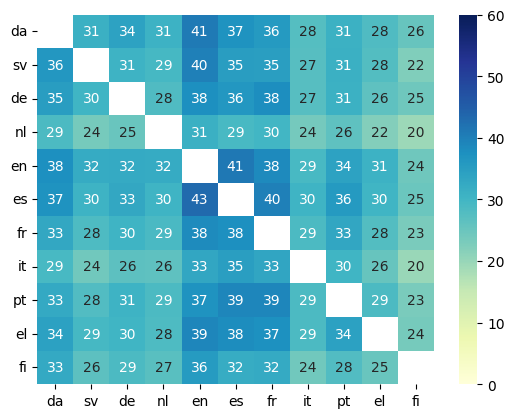


ep-gpt


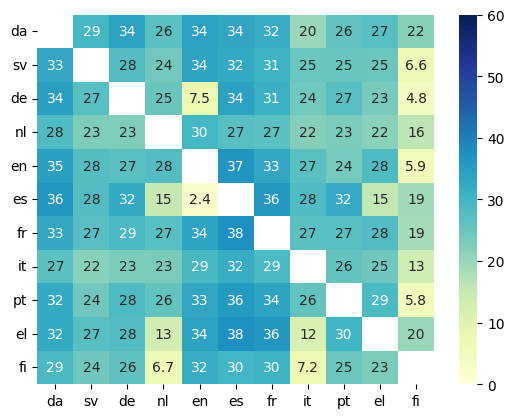


flores-deepl


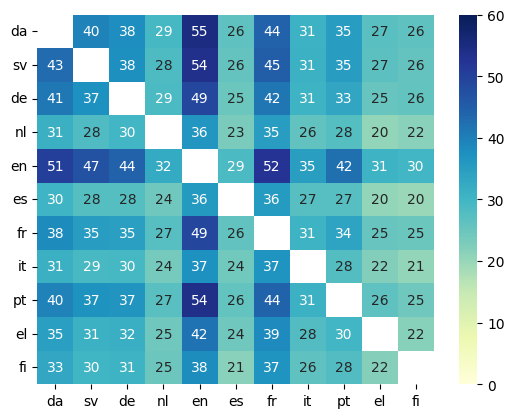


flores-gpt


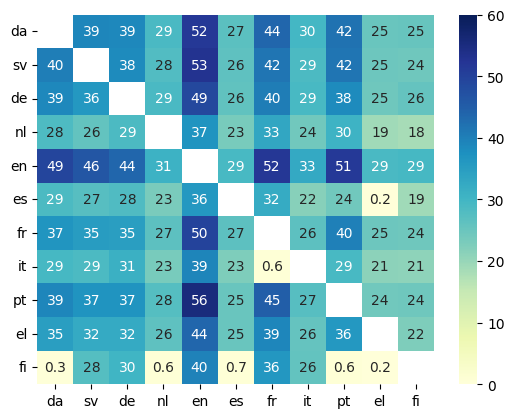


opus-deepl


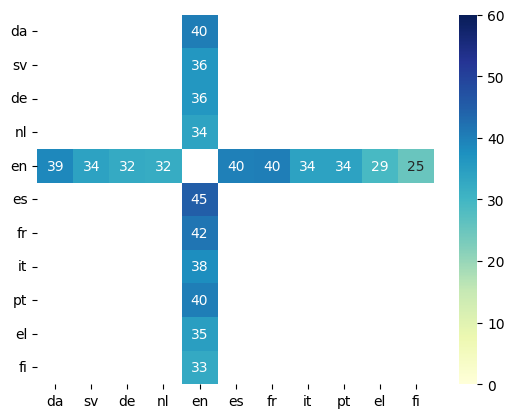


opus-gpt


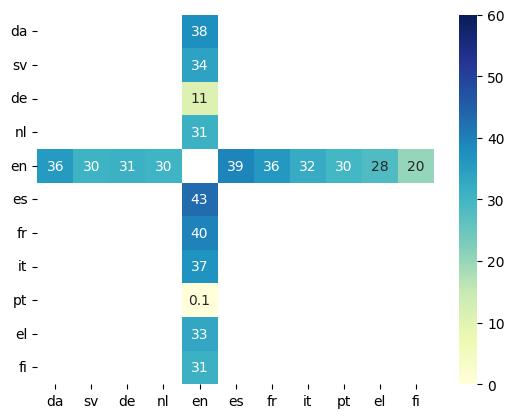

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
for key in res2df:
    out = res2df[key]['df'].round(1)
    out = out.reindex(index=order, columns=order)
    print(key)
    sns.heatmap(out, annot=True, cmap="YlGnBu", cbar=True, vmin=0, vmax=60)
    plt.yticks(rotation=0)
    plt.show()
    print()

* Now we can check if the pairs we assumed to be misaligned have very low BLEU scores


In [6]:
from os.path import join
import json
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

mismatches = {
    'ep-gpt':[],
    'flores-gpt':[],
    'opus-gpt':[],
}

for prefix, info in prefix2file.items():
    dataset, translator, s, t = prefix.split('-')
    key = f'{dataset}-{translator}'
    outlines = info['log']['out_lines']
    if outlines!=400:
        score = res2df[key]['df'].loc[s, t]
        mismatches[key].append((f'{s}-{t}', score))

for key in mismatches:
    print(key)
    for item in sorted(mismatches[key], key=lambda x: x[1], reverse=True):
        label, score = item
        print(f'{label}: {score:.2f}')
    print()

ep-gpt
da-it: 19.91
es-el: 15.40
es-nl: 15.05
it-fi: 13.18
el-nl: 12.86
el-it: 11.54
de-en: 7.48
fi-it: 7.24
fi-nl: 6.73
sv-fi: 6.63
en-fi: 5.88
pt-fi: 5.85
de-fi: 4.77
es-en: 2.41

flores-gpt
fi-es: 0.65
it-fr: 0.62
fi-nl: 0.60
fi-pt: 0.58
fi-da: 0.29
es-el: 0.23
fi-el: 0.22

opus-gpt
de-en: 10.65
pt-en: 0.11



## Post-Processed Evaluation
* Alignment was conducted on Google Collab using `bertalign`
* The notebook can be found [here](https://colab.research.google.com/drive/1xlwQPctsOGjZB2NpB9WNtzWPae_Oj4gt?usp=sharing)

In [13]:

from scripts.post_process import post_triplet_align, load_aligned_sents_from_file
import os
from os.path import join
src2hyp_fo = 'source2translations'
src2ref_fo = 'source2reference'

files = [f.replace('.jsonl', '') for f in os.listdir(src2hyp_fo)]


In [14]:
for fi in files:
    dataset, translator, s, t = fi.split('-')
    src_sents_a, mt_sents_a = load_aligned_sents_from_file(fi, folder=src2hyp_fo)
    key = f'{dataset}-{s}-{t}'
    src_sents_o, ref_sents_o = load_aligned_sents_from_file(key, folder=src2ref_fo)
    post_triplet_align(
        src_sents_org=src_sents_o,
        src_sents_ali=src_sents_a,
        ref_sents_org=ref_sents_o,
        mt_sents_ali=mt_sents_a,
        src_lang=s,
        ref_lang=t,
        folder_path='post_triplets',
        prefix=f'{dataset}-{translator}-'
    )

384 sents aligned for da and de
385 sents aligned for da and el
384 sents aligned for da and en
383 sents aligned for da and es
387 sents aligned for da and fi
384 sents aligned for da and fr
363 sents aligned for da and it
384 sents aligned for da and nl
382 sents aligned for da and pt
386 sents aligned for da and sv
372 sents aligned for de and da
366 sents aligned for de and el
377 sents aligned for de and en
369 sents aligned for de and es
379 sents aligned for de and fi
378 sents aligned for de and fr
361 sents aligned for de and it
372 sents aligned for de and nl
369 sents aligned for de and pt
370 sents aligned for de and sv
394 sents aligned for el and da
391 sents aligned for el and de
392 sents aligned for el and en
391 sents aligned for el and es
395 sents aligned for el and fi
391 sents aligned for el and fr
376 sents aligned for el and it
387 sents aligned for el and nl
387 sents aligned for el and pt
389 sents aligned for el and sv
382 sents aligned for en and da
386 sent

In [15]:
from scripts.scoring import ResultProducer
import os
from os.path import join

files = os.listdir('post_triplets')
os.makedirs('post_results', exist_ok=True)

result_setup = ['ep-gpt', 'ep-deepl', 'flores-gpt',
                'flores-deepl', 'opus-gpt', 'opus-deepl']

for rs in result_setup:
    l2f = {f.replace(f'{rs}-', '').replace('.jsonl', '')
                     : join('post_triplets', f) for f in files if f.startswith(rs)}
    rp = ResultProducer(label2files=l2f)
    rp.compute_results()
    rp.store_results(join('post_results', f'{rs}.csv'))

In [16]:
import os
from os.path import join
from scripts.scoring import create_matrix_from_csv
res_files = os.listdir('post_results')
post_res2df = {f.replace('.csv', ''): {'file': join(
    'post_results', f), 'df': None} for f in res_files}

for rs, content in post_res2df.items():
    file_path = content['file']
    df = create_matrix_from_csv(file_path)
    post_res2df[rs]['df'] = df

ep-deepl


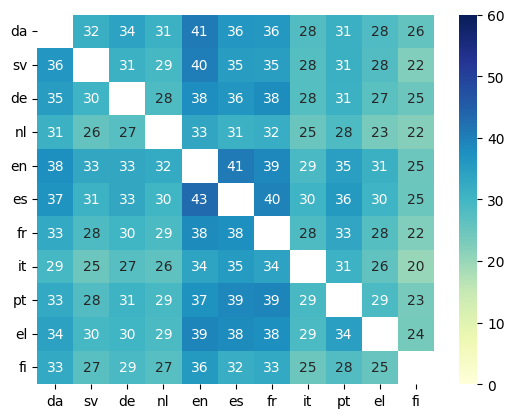


ep-gpt


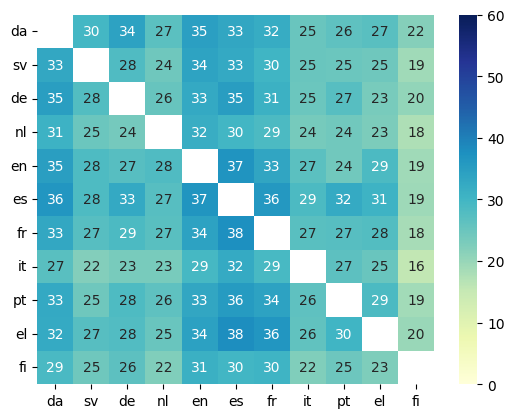


flores-deepl


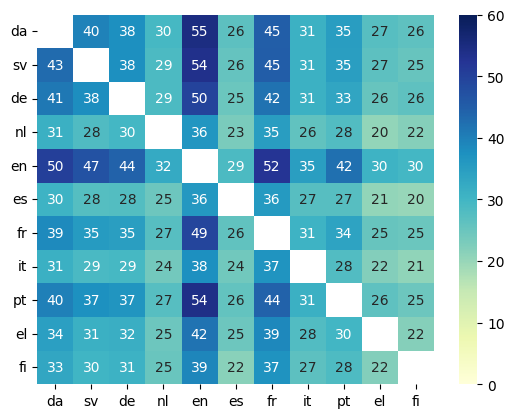


flores-gpt


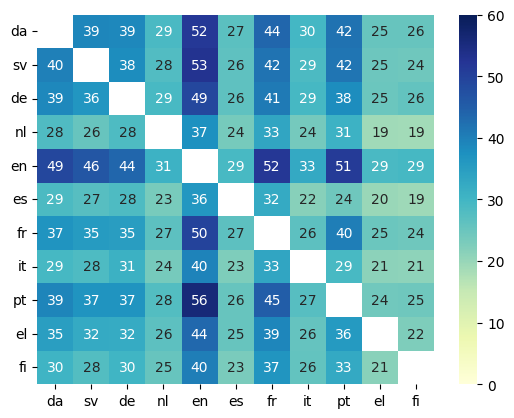


opus-deepl


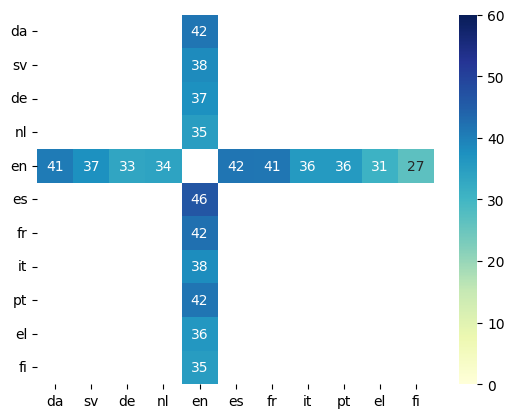


opus-gpt


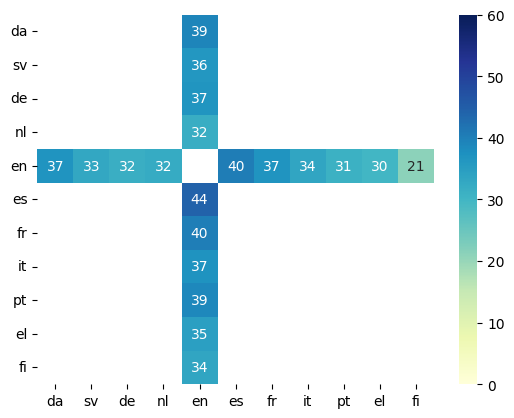

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
order = ['da', 'sv', 'de', 'nl', 'en', 'es', 'fr', 'it', 'pt', 'el', 'fi']
for key in post_res2df:
    out = post_res2df[key]['df'].round(1)
    out = out.reindex(index=order, columns=order)
    print(key)
    sns.heatmap(out, annot=True, cmap="YlGnBu", cbar=True, vmin=0, vmax=60)
    plt.yticks(rotation=0)
    plt.show()
    print()

In [19]:
import numpy as np
for key in post_res2df:
    out = post_res2df[key]['df'] - res2df[key]['df']
    print(key)
    print('mean', f'{np.nanmean(out.values):.2f}')
    print('max', f'{np.nanmax(out.values):.2f}')
    print('min', f'{np.nanmin(out.values):.2f}')
    print()

ep-deepl
mean 0.32
max 2.43
min -0.91

ep-gpt
mean 2.15
max 34.19
min -0.56

flores-deepl
mean 0.09
max 0.74
min -0.23

flores-gpt
mean 1.74
max 32.75
min -0.29

opus-deepl
mean 1.52
max 3.40
min 0.23

opus-gpt
mean 4.45
max 38.80
min 0.23



* We can check if the misaligned were improved with the alignment

In [20]:
from os.path import join
import json
with open(join('translations', 'info.json'), 'r') as f:
    prefix2file = json.load(f)

mismatches = {
    'ep-gpt': [],
    'flores-gpt': [],
    'opus-gpt': [],
}

for prefix, info in prefix2file.items():
    dataset, translator, s, t = prefix.split('-')
    key = f'{dataset}-{translator}'
    outlines = info['log']['out_lines']
    if outlines != 400:
        score = res2df[key]['df'].loc[s, t]
        improved = post_res2df[key]['df'].loc[s, t]
        mismatches[key].append((f'{s}-{t}', score, improved))

for key in mismatches:
    print(key)
    for item in sorted(mismatches[key], key=lambda x: x[1], reverse=True):
        label, score, improved = item
        print(f'{label}: {score:.2f} -> {improved:.2f}')
    print()

ep-gpt
da-it: 19.91 -> 25.13
es-el: 15.40 -> 30.55
es-nl: 15.05 -> 27.40
it-fi: 13.18 -> 15.49
el-nl: 12.86 -> 25.28
el-it: 11.54 -> 26.05
de-en: 7.48 -> 32.61
fi-it: 7.24 -> 22.30
fi-nl: 6.73 -> 22.44
sv-fi: 6.63 -> 19.18
en-fi: 5.88 -> 19.21
pt-fi: 5.85 -> 18.76
de-fi: 4.77 -> 20.43
es-en: 2.41 -> 36.59

flores-gpt
fi-es: 0.65 -> 23.09
it-fr: 0.62 -> 33.37
fi-nl: 0.60 -> 25.39
fi-pt: 0.58 -> 32.68
fi-da: 0.29 -> 30.45
es-el: 0.23 -> 19.87
fi-el: 0.22 -> 21.36

opus-gpt
de-en: 10.65 -> 36.60
pt-en: 0.11 -> 38.91

